In [178]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from zipfile import ZipFile
import cv2
from tqdm.notebook import tqdm

import tensorflow
from tensorflow import keras
import tensorflow as tf

from PIL import Image
from PIL.ExifTags import TAGS
import io

from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import UpSampling2D, Concatenate, Reshape, Conv2D

from tensorflow.python.keras.utils import generic_utils
from tensorflow.keras.layers import Layer, InputSpec

from tensorflow.keras.utils import img_to_array

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy

import random
from tensorflow.keras.layers import Concatenate,ZeroPadding2D,Conv2D,Reshape, BatchNormalization, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation,SpatialDropout2D,UpSampling2D
from sklearn.metrics import f1_score,accuracy_score,classification_report,confusion_matrix,roc_curve,auc


# PART A - PROJECT OBJECTIVE: To build a face detection system

# A. Import and read ‘images.npy’.

In [2]:
images = np.load("images.npy", allow_pickle=True)


# 1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [3]:
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

masks = np.zeros((images.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float32)
X = np.zeros((images.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT,3), dtype=np.float32)

for index in range(images.shape[0]):
    # Resize image
    image = images[index][0]
    mask_info = images[index][1]
    resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)

    # If the image has less than 3 channels, convert it to RGB
    if len(resized_image.shape) < 3 or resized_image.shape[2] == 1:
        resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    else:
        # Already RGB, ensure consistent channel order
        resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Convert the list back to a NumPy array
    X[index] = preprocess_input(np.array(resized_image_rgb[:, :, :3], dtype=np.float32))
    
    for cnt in range(len(images[index][1])):
        x0 = int(images[index][1][cnt]['points'][0]['x'] * IMAGE_WIDTH)
        y0 = int(images[index][1][cnt]['points'][0]['y'] * IMAGE_HEIGHT)
        x1 = int(images[index][1][cnt]['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(images[index][1][cnt]['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y0:y1, x0:x1] = 1
         
Y=np.array(masks)


# 1.C. Split the data into train and test[400:9].

In [4]:
# Training data: First 400 samples
train_X = X[:400]
train_Y = Y[:400]

# Test data: Next 9 samples
test_X = X[400:409]
test_Y = Y[400:409]

In [5]:
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(400, 224, 224, 3) (400, 224, 224) (9, 224, 224, 3) (9, 224, 224)


# 1.D. Select random image from the train data and display original image and masked image

396


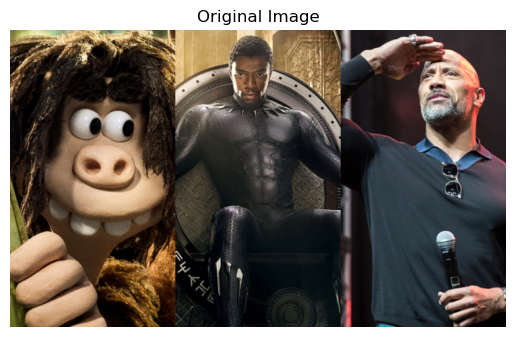

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


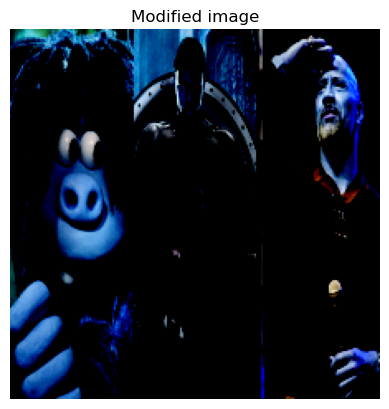

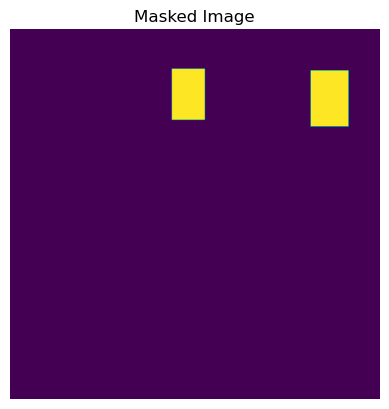

In [6]:
# Select a random image from the training set
random_index = random.randint(0, len(train_X) - 1)
print(random_index)

# Display the original image
image_to_view = images[random_index][0]
plt.imshow(image_to_view)
plt.title("Original Image")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the Modified image
modified_image = train_X[random_index]
plt.imshow(modified_image)
plt.title("Modified image")
plt.axis('off')
plt.show()

# Display the masked image
masked_imageY = train_Y[random_index]
plt.imshow(masked_imageY)
plt.title("Masked Image")
plt.axis('off')
plt.show()


# 2.A. Design a face mask detection model.

In [7]:
ALPHA = 1  # Width hyperparameter for MobileNet. Values can be 0.25, 0.5, 0.75, 1.0. Higher width means more accuracy but slower.
IMAGE_SIZE = 224  # The size of the input images

# Define a simple convolutional block with BatchNormalization and ReLU activation
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    # Apply a Convolutional Layer
    conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal', strides=strides, name=prefix + '_conv')(prevlayer)
    # Apply Batch Normalization
    conv = BatchNormalization(name=prefix + 'BatchNormalization')(conv)
    # Apply ReLU activation function
    conv = Activation('relu', name=prefix + 'ActivationLayer')(conv)
    return conv

# Function to create the model
def create_model(trainable=True):
    # Load MobileNet model pre-trained on ImageNet data
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights='imagenet')

    # Set the layers' trainability
    for layer in model.layers:
        layer.trainable = trainable

    # Extract outputs from different layers for skip connections
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output

    # Upsampling and concatenating layers to create a U-Net like architecture
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    # conv10 = SpatialDropout2D(0.2)(conv10)

    # Final Convolutional Layer with a Sigmoid activation function
    x = Conv2D(1, (1, 1), activation='sigmoid')(conv10)
    # Reshaping the output to the desired image size
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)

    # Return the model
    return Model(inputs=model.input, outputs=x)


In [9]:
model = create_model(False)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

# 2.B. Design your own Dice Coefficient and Loss function

In [10]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())


In [11]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

# 2.C. Train and tune the model as required

In [12]:
model.compile(loss=loss, optimizer='ADAM', metrics=[dice_coefficient], run_eagerly=True)

In [13]:
# tensorflow.config.run_functions_eagerly(True)
model.fit(train_X, train_Y, epochs = 15, batch_size = 32, validation_data=(test_X, test_Y))

Epoch 1/15

13/13 [==============================] - 248s 19s/step - loss: 1.4250 - dice_coefficient: 0.4206 - val_loss: 15.3273 - val_dice_coefficient: 0.1939
Epoch 2/15
13/13 [==============================] - 246s 19s/step - loss: 0.8957 - dice_coefficient: 0.5380 - val_loss: 15.3268 - val_dice_coefficient: 0.1939
Epoch 3/15
13/13 [==============================] - 241s 18s/step - loss: 0.7501 - dice_coefficient: 0.5881 - val_loss: 15.1878 - val_dice_coefficient: 0.1943
Epoch 4/15
13/13 [==============================] - 145s 10s/step - loss: 0.6496 - dice_coefficient: 0.6328 - val_loss: 14.3855 - val_dice_coefficient: 0.1967
Epoch 5/15
13/13 [==============================] - 106s 8s/step - loss: 0.5505 - dice_coefficient: 0.6749 - val_loss: 11.3780 - val_dice_coefficient: 0.2155
Epoch 6/15
13/13 [==============================] - 111s 8s/step - loss: 0.4838 - dice_coefficient: 0.7048 - val_loss: 8.4239 - val_dice_coefficient: 0.2488
Epoch 7/15
13/13 [==============================

# 2.D. Evaluate and share insights on performance of the model.

The project focused on utilizing a pre-trained MobileNet for transfer learning, enhanced with U-Net layers, to identify facial masks in images. The model, optimized with binary cross-entropy loss and Adam optimizer, evaluated performance using the dice coefficient. Key callbacks like run eagerly, and learning rate reduction were employed. The data was divided into an 9 images as test set and reamining as train, achieving a training loss of 0.74 and a dice coefficient of 0.8743. Increasing the no of epochs from 10 to 15 help improved the accuracy of the model.

# 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image

1/1 [==============================] - 1s 544ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


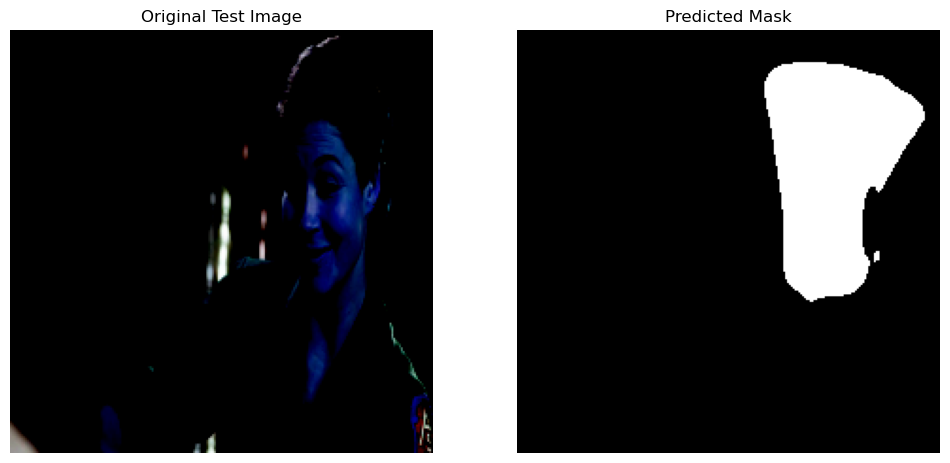

In [22]:
# Select the test image with index 3
test_image = test_X[5]

test_image_batch = np.expand_dims(test_image, axis=0)

# Predict the mask for the selected test image
predicted_mask_batch = model.predict(test_image_batch)
predicted_mask = predicted_mask_batch[0]

# If the predicted mask is not binary, apply a threshold to get a binary mask
# This step is necessary if your model outputs probabilities rather than binary values
threshold = 0.5  # This threshold might need adjustment
predicted_mask = (predicted_mask > threshold).astype(np.float32)

# Visualize the test image and the predicted mask
plt.figure(figsize=(12, 6))

# Display the original test image
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze())  # Squeeze is used to remove single-dimensional entries from the shape of an array.
plt.title("Original Test Image")
plt.axis('off')

# Display the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze(), cmap='gray')  # Apply the same squeeze here if necessary
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


# PART B - PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given

In [45]:
import sys
!{sys.executable} -m pip install opencv-python

# 1. Read/import images from folder ‘training_images’

In [52]:
root = 'training_images'

fnames=os.listdir(root)

In [53]:
len(fnames)

1091

In [54]:
for i in range(5):
    print(os.path.join(root, fnames[i]))

training_images\real_00001.jpg
training_images\real_00002.jpg
training_images\real_00003.jpg
training_images\real_00004.jpg
training_images\real_00005.jpg


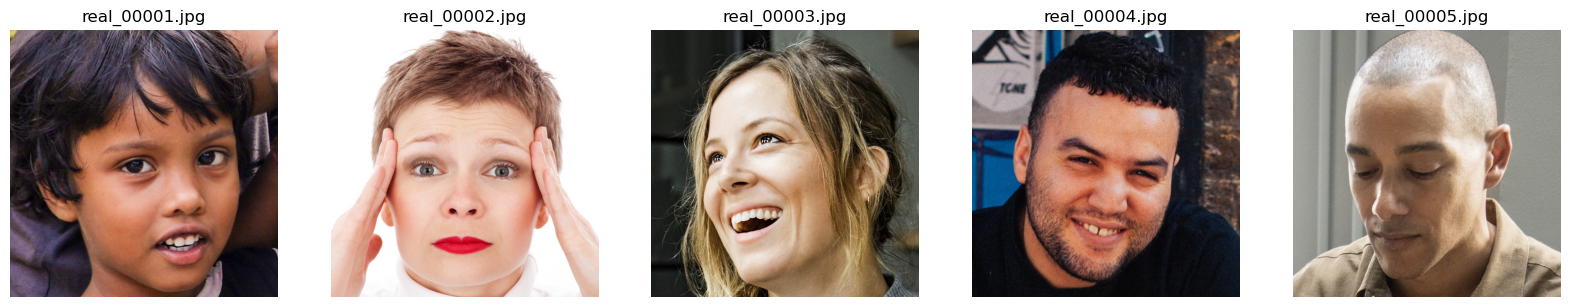

In [55]:
fig , axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
axs = axs.flatten()
for i in range(5):
    filepath = os.path.join(root, fnames[i])
    img = Image.open(filepath)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(fnames[i])
    
plt.show() 

# 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images

In [212]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [213]:
for filename in os.listdir(root):
    filepath = os.path.join(root, filename)
    img = cv2.imread(filepath)
    detect = face_classifier.detectMultiScale(img)
    cols=['x','y','w','h','Total_faces','Image_Name']   
    df_list = []  
        
    for cnt in range(len(detect)):     
        new_row = [detect[cnt][0],
                   detect[cnt][1],
                   detect[cnt][2],
                   detect[cnt][3],
                   len(detect),
                   filename] 
        
        df_list.append(new_row)
                   
df2 = pd.DataFrame(df_list,columns = cols)

# 3. From the same loop above, extract metadata of the faces and write into a DataFrame

In [214]:
df2 = pd.DataFrame(df_list,columns = cols)

# 4. Save the output Dataframe in .csv format. 

In [215]:
df2.to_csv('C:/Users/Anjali V Sidhwani/Desktop/output.csv',index=False)

# PART C - PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. 

# 1. Unzip, read and Load data(‘PINS.zip’) into session

In [113]:
# Define the path to the zip file and the extraction directory
zip_path = os.getcwd() +'\PINS.zip'
extract_dir = os.getcwd()
base_dir= os.path.join(extract_dir, 'PINS')


In [ ]:
with ZipFile('PINS.zip', 'r') as zip:
  zip.extractall()

In [141]:
# Read and Load data
images = []
labels = []

metadata = []

path=base_dir

folders = os.listdir(path)

for folderName in folders:
    for file in os.listdir(os.path.join(path, folderName)): 
          image_path= os.path.join(os.path.join(path, folderName), file)
          images.append(image_path)
          labels.append(folderName)

In [133]:
# Convert Lists to NumPy Arrays

images_array = np.array(images)
labels_array = np.array(labels)

print("Images array shape:", images_array.shape)
print("Labels array shape:", labels_array.shape)


Images array shape: (10770,)
Labels array shape: (10770,)


In [143]:
def image_path(n):
       return images_array[n] 

In [144]:
def load_image(path, target_size=(224, 224)):
    img = cv2.imread(path, 1)
    img = (img / 255.).astype(np.float32)      
    img = cv2.resize(img, target_size)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [145]:
n = np.random.randint(1, len(images_array))
img_path = image_path(n)
img = load_image(img_path)

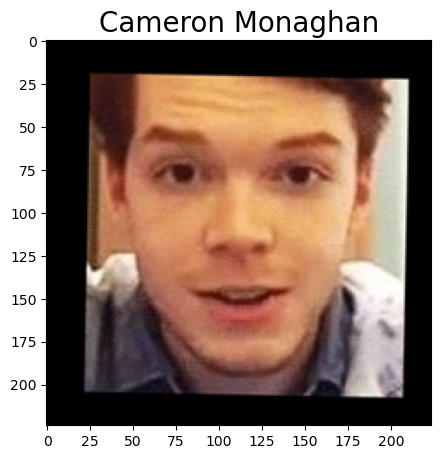

In [146]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

# 2. Write function to create metadata of the image

In [147]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    


In [148]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts



# 3. Write a loop to iterate through each and every image and create metadata for all the images

In [149]:
metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [150]:
metadata[0]

PINS\pins_Aaron Paul\Aaron Paul0_262.jpg

In [151]:
len(metadata)

10770

# 4. Generate Embeddings vectors on the each face in the dataset

In [153]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [154]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [155]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [202]:
def create_embedding(model, metadata):
    try:
        # Retrieve the actual image path from the IdentityMetadata object
        image_path = metadata.image_path()

        # Load and preprocess the image
        img = load_image(image_path, target_size=(224, 224))  # Adjust size to your model's input
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        #img_array = preprocess_input(img_array) # Preprocess the image

        # Generate embedding
        embedding = model.predict(img_array)
        return embedding.flatten()  # Flatten the embedding if necessary
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros((2622,))  # Return a zero vector for failed embeddings

# Example usage
embeddings = [create_embedding(vgg_face_descriptor, meta) for meta in metadata]

1/1 [==============================] - 0s 360ms/step


In [206]:
np.savetxt("embeddings.csv",
        embeddings,
        delimiter =", ",
        fmt ='%s')

**I had saved embeddings and later used it as I had restarted kernel. Running of embeddings took about 2+ hours and I could not afford to re-run kernel. 

In [157]:
embeddings=  np.loadtxt("embeddings.csv", delimiter=",")

# 5. Build distance metrics for identifying the distance between two similar and dissimilar images.

In [158]:
def distance(i, j):
    distance = np.linalg.norm(embeddings[i] - embeddings[j])
    return distance  

In [159]:
def show_pair(i, j):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(i, j):.2f}')
    plt.subplot(121)
       
    plt.imshow(load_image(metadata[i].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[j].image_path()))

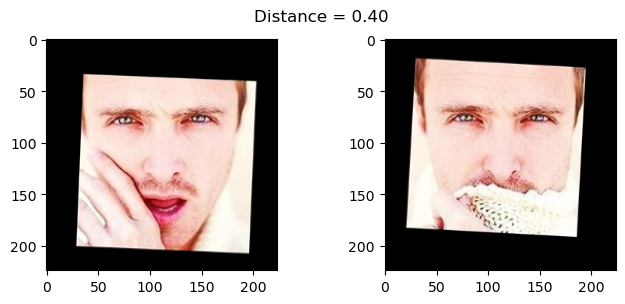

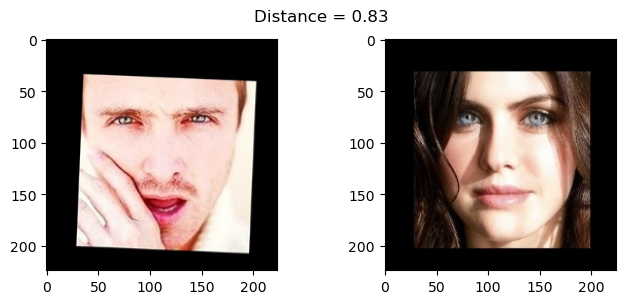

In [160]:
show_pair(2, 3)
show_pair(2, 180)

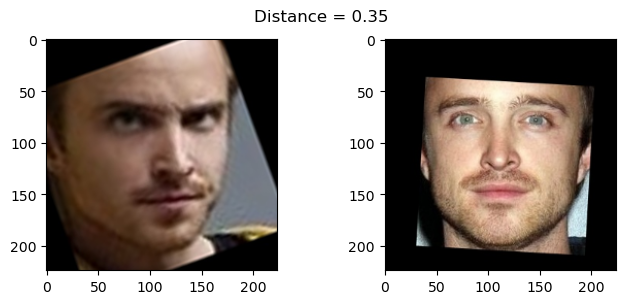

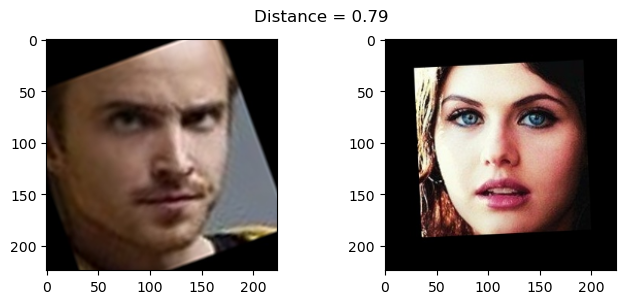

In [161]:
show_pair(30, 31)
show_pair(30, 100)

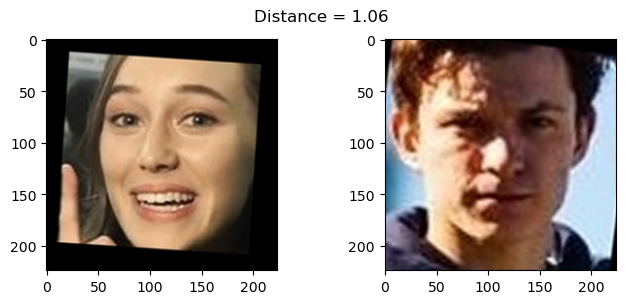

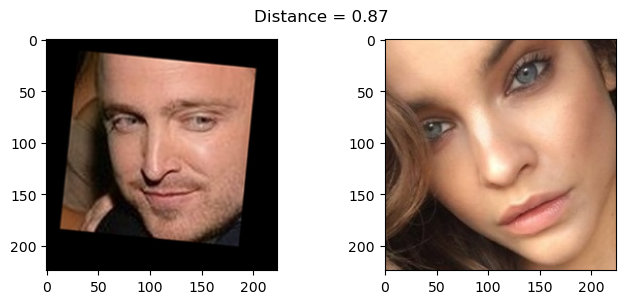

In [164]:
show_pair(400, 10090)
show_pair(70,1089)

# 6. Use PCA for dimensionality reduction

In [165]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [166]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [172]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Reduce dimensions using PCA

In [173]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416793  18.9486784   22.94242506 ...  99.99999983  99.99999999
 100.        ]


In [169]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


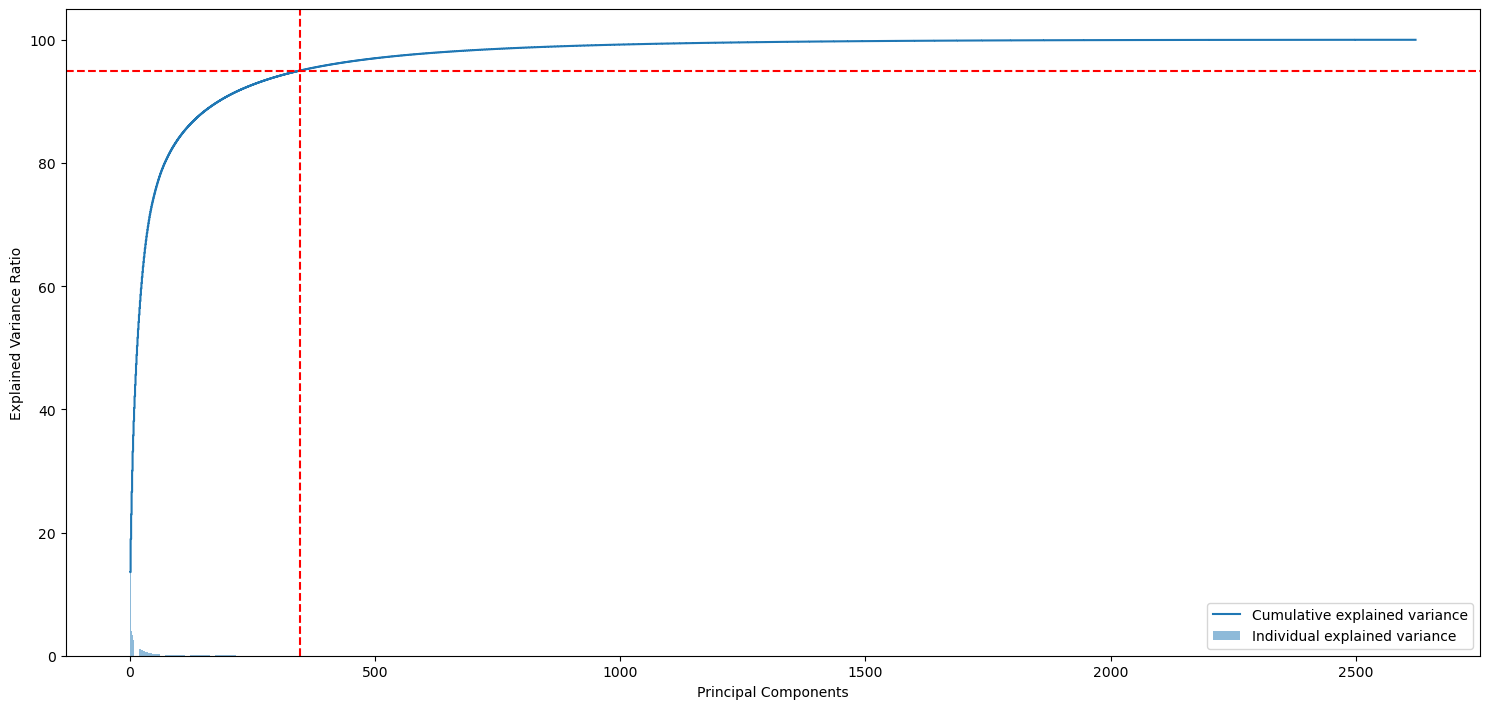

In [171]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [174]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 2020, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

In [253]:
# params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

# svc = GridSearchCV(SVC(random_state = 2020), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
# svc.fit(X_train_pca, y_train)

# print('Best estimator found by grid search:')
# print(svc.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best estimator found by grid search:
SVC(C=10, class_weight='balanced', gamma=0.0001, random_state=2020)


# 7. Build an SVM classifier in order to map each image to its right person

In [175]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 42)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [179]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [180]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

# 8. Import and display the the test images

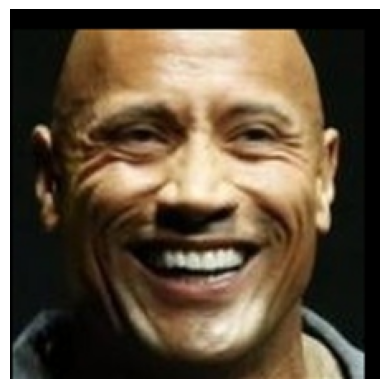

In [204]:
test_image_path1=os.path.join(extract_dir,"Dwayne Johnson4.jpg")
img1 = cv2.imread(test_image_path1) # Load the image
img1 = cv2.resize(img1, dsize = (224,224))
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
img1 = (img1/ 255.).astype(np.float32)
img1_array = np.array(img1)
plt.imshow(img1_array)    # Display the image with faces highlighted
plt.axis("off")  # Turn off axis labels
plt.show()



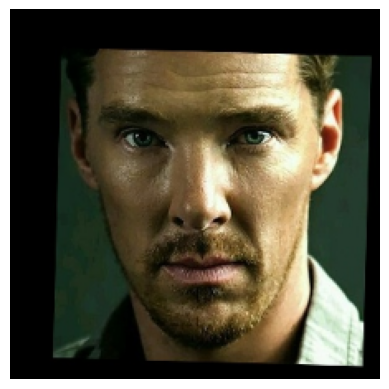

In [205]:
test_image_path2=os.path.join(extract_dir,"Benedict Cumberbatch9.jpg")
img2 = cv2.imread(test_image_path2) # Load the image
img2 = cv2.resize(img2, dsize = (224,224))
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
img2 = (img2/ 255.).astype(np.float32)
img2_array = np.array(img2)
plt.imshow(img2_array)    # Display the image with faces highlighted
plt.axis("off")  # Turn off axis labels
plt.show()

# 9. Use the trained SVM model to predict the face on both test images

1/1 [==============================] - 1s 591ms/step
Dwayne Johnson


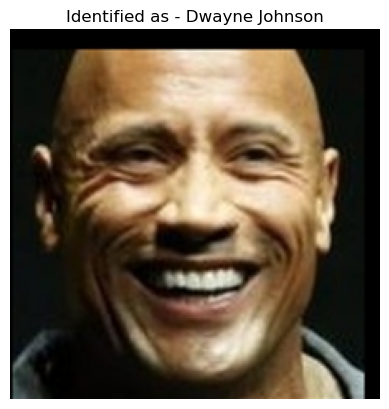

In [209]:
 # Obtain embedding vector for sample image
embedding = vgg_face_descriptor.predict(np.expand_dims(img1, axis = 0))[0]
  # Scaled the vector and reshape
embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  #return sample_img, actual_name, pred_name
    
print(pred_name)

plt.imshow(img1_array)    # Display the image with faces highlighted
plt.axis("off")  # Turn off axis labels
plt.title(f'Identified as - {pred_name}');
plt.show()


1/1 [==============================] - 1s 570ms/step
Benedict Cumberbatch


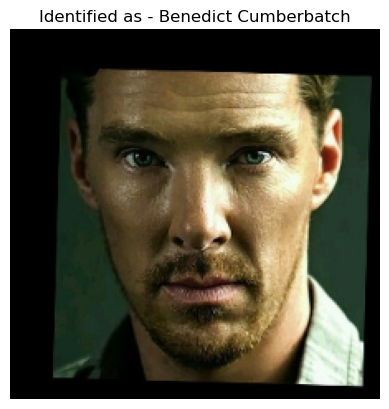

In [210]:
 # Obtain embedding vector for sample image
embedding = vgg_face_descriptor.predict(np.expand_dims(img2, axis = 0))[0]
  # Scaled the vector and reshape
embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
pred_name2 = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  #return sample_img, actual_name, pred_name
    
print(pred_name2)

plt.imshow(img2_array)    # Display the image with faces highlighted
plt.axis("off")  # Turn off axis labels
plt.title(f'Identified as - {pred_name2}');
plt.show()